In [1]:
"""
Extreme ozone
Author @Xingpei Ye

Please use python environment of: extreme_ml

2023/12/07,  initial version
"""

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import os

# To load mat file from MATLAB
import scipy.io as scio

import pickle

# to make the output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.weight"] = "normal"

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:
feature_opt = 'EMEP_v2'

target_variable = 'O3_50'
metric_opt = 'f1' # f1, roc_auc, accuracy, f2
algri_opt = 'lgbm'
time_budget_opt = 60*3 # seconds

ML_opt = feature_opt+'_'+target_variable+'_'+metric_opt+'_'+algri_opt+'_'+str(time_budget_opt)


# read siteinfo from csv file
siteinfo = pd.read_csv('../TOAR2/O3_MDA8_EU_EMEP/Metadata_O3_EMEP_customized.csv')

import glob
for filepath in glob.iglob('./training_data/'+feature_opt+'_*.mat'):
    siteid_now = int(filepath[-10:-4])
    id_todo = siteinfo.loc[siteinfo['id']==siteid_now].index[0]
    print(id_todo)
    print([siteinfo['station_name'].iloc[id_todo]])
    print([siteinfo['station_country'].iloc[id_todo]])


    # feature name
    feature_name_csv = pd.read_csv('./training_data/'+feature_opt+'_'+str(siteid_now)+'_feature_name.csv')
    feature_name = feature_name_csv.columns

    # read data from MATLAB file
    training_data_matfile = scio.loadmat('./training_data/'+feature_opt+'_'+str(siteid_now)+'.mat')
    training_data_ori = training_data_matfile['training_data_final']
    nfeature = training_data_matfile['nfeature'].astype(int)[0][0]
    nlabel = training_data_matfile['nlabel'].astype(int)[0][0]

    ''' step 1: prepare data'''

    # voncert to dataframe format and add label to dataframe
    training_data = pd.DataFrame(training_data_ori) 
    training_data.columns = feature_name

    # select features and label we need
    training_data_feature = training_data.drop(training_data.columns[nfeature:], axis=1)
    training_data_label = training_data[target_variable].copy()
    training_data_combine = training_data_feature.join(training_data_label)

    # if site is too high, U/V850 will be NaN, then we delete these two features
    if training_data_combine['U850'].isnull().sum() > 0:
        training_data_combine = training_data_combine.drop(columns={'U850','V850','H850'})
        nfeature = nfeature - 3
        print(siteid_now)
        print('droping 850')

    if training_data_combine['U500'].isnull().sum() > 0:
        training_data_combine = training_data_combine.drop(columns={'U500','V500','H500','OMEGA500'})
        nfeature = nfeature - 4

    # drop all invalid nan data
    training_data_nonan = training_data_combine.dropna(axis=0, how='any')

    # select features and label
    X = training_data_nonan.drop(training_data_nonan.columns[nfeature:], axis=1)
    y = training_data_nonan[target_variable].copy()

    # split training set and testing set
    # preserving the percentage of samples for each class
    from sklearn.model_selection import train_test_split

    O3_training, O3_test, O3_training_labels, O3_test_labels = train_test_split(X, y,
                                                        stratify=y, 
                                                        test_size=0.2,
                                                        random_state=2001110281)

    # print imbalanced degree (normal counts/extreme counts)
    counts = O3_training_labels.value_counts()
    imbalance_degree = counts[0]/counts[1]
    print('Before re-sampling')
    print('Normal counts = ', counts[0])
    print('Extreme counts = ', counts[1])
    print('Imbalance degree = ',imbalance_degree)
    
    if imbalance_degree >= 1 and imbalance_degree <= 4:
        spw_opt = imbalance_degree 
    elif imbalance_degree>4:
        spw_opt = [2,3,4,imbalance_degree]
    elif imbalance_degree<1 and imbalance_degree>= 1/4:
        spw_opt = imbalance_degree
    elif imbalance_degree < 1/4:
        spw_opt = [imbalance_degree, 1/4, 1/3, 1/2]


    ''' step 2: AutoML to find best ML model '''
    from flaml import AutoML

    # if there is already automl object file, we just load it instead of training again
    if os.path.isfile('./automl_data/'+ML_opt+'_'+str(siteid_now)+'.pkl'):
        with open('./automl_data/'+ML_opt+'_'+str(siteid_now)+'.pkl', 'rb') as f:
            automl = pickle.load(f)

    else: # else we create new auto-ml object
        automl = AutoML()
        settings = {
            "time_budget": time_budget_opt,  # total running time in seconds
            "metric": 'f1', # 'accuracy','roc_auc','f1', or f2
            "estimator_list": [algri_opt],
            "task": 'classification',  # task type
            "seed": 2001110281,    # random seed
            "retrain_full": False,
        }
        from flaml import tune
        if type(spw_opt) == np.float64: # given spw_opt
            settings["custom_hp"] = {
                "lgbm": {
                    "scale_pos_weight": {
                        "domain": spw_opt,
                        "init_value": spw_opt,
                    }
                }
            }
        else: # let flaml select spw
            settings["custom_hp"] = {
                "lgbm": {
                    "scale_pos_weight": {
                        "domain": tune.choice(spw_opt),
                        "init_value": spw_opt[0],
                    }
                }
            }
            
        # The main flaml automl API
        automl.fit(X_train=O3_training, y_train=O3_training_labels, **settings)

        # pickle and save the automl object
        with open('./automl_data/'+ML_opt+'_'+str(siteid_now)+'.pkl', 'wb') as f:
            pickle.dump(automl, f, pickle.HIGHEST_PROTOCOL)

        # retrieve best config, this is the internal validation of auto-ml
        print('Best hyperparmeter config:', automl.best_config)
        print('Best metric on validation data: {0:.4g}'.format(1-automl.best_loss))
        print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))

        '''compute predictions of testing dataset''' 
        import sklearn.metrics
        O3_pred = automl.predict(O3_test)
        O3_pred_proba = automl.predict_proba(O3_test)[:,1]

        # confusion matrix
        tn, fp, fn, tp = sklearn.metrics.confusion_matrix(O3_test_labels, O3_pred).ravel()

        # compute different metric values on testing dataset
        d = {
            'siteid': [siteid_now],
            'station name': [siteinfo['station_name'].iloc[id_todo]],
            'station contry': [siteinfo['station_country'].iloc[id_todo]],
            'total samples': [counts[0]+counts[1]],
            'imbalance degree': [imbalance_degree],
            'weight factor': [automl.best_config['scale_pos_weight']],
            'f1': [sklearn.metrics.f1_score(O3_test_labels,O3_pred)],
            'recall': [sklearn.metrics.recall_score(O3_test_labels,O3_pred)],
            'precision': [sklearn.metrics.precision_score(O3_test_labels,O3_pred)],
            'f2': [sklearn.metrics.fbeta_score(O3_test_labels,O3_pred,beta=2)],
            'roc_auc': [sklearn.metrics.roc_auc_score(O3_test_labels,O3_pred_proba)],
            'accuracy': [sklearn.metrics.accuracy_score(O3_test_labels,O3_pred)],
            'log_loss': [sklearn.metrics.log_loss(O3_test_labels,O3_pred_proba)],
            }
        df = pd.DataFrame(data=d)
        df = df.round(4)

        if siteid_now==415421: # loop imbalance degree <= 6 or all sites
            df.to_csv('./automl_data/performance_'+ML_opt+'.csv', index=False) # always turn this on
        else:
            df.to_csv('./automl_data/performance_'+ML_opt+'.csv', mode='a', index=False, header=False)
        df

0
['Östad']
['Sweden']
Before re-sampling
Normal counts =  834
Extreme counts =  40
Imbalance degree =  20.85


/Users/sebestian/miniconda3/envs/extreme_ml/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-03-14 17:27:15,254	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-03-14 17:27:15,504	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


[flaml.automl.logger: 03-14 17:27:16] {1679} INFO - task = classification
[flaml.automl.logger: 03-14 17:27:16] {1690} INFO - Evaluation method: cv
[flaml.automl.logger: 03-14 17:27:16] {1788} INFO - Minimizing error metric: 1-f1
[flaml.automl.logger: 03-14 17:27:16] {1900} INFO - List of ML learners in AutoML Run: ['lgbm']
[flaml.automl.logger: 03-14 17:27:16] {2218} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 03-14 17:27:16] {2344} INFO - Estimated sufficient time budget=704s. Estimated necessary time budget=1s.
[flaml.automl.logger: 03-14 17:27:16] {2391} INFO -  at 0.1s,	estimator lgbm's best error=1.0000,	best estimator lgbm's best error=1.0000
[flaml.automl.logger: 03-14 17:27:16] {2218} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 03-14 17:27:16] {2391} INFO -  at 0.2s,	estimator lgbm's best error=1.0000,	best estimator lgbm's best error=1.0000
[flaml.automl.logger: 03-14 17:27:16] {2218} INFO - iteration 2, current learner lgbm
[flaml.automl

KeyboardInterrupt: 

In [ ]:
# loop sites to calculate shap values
import shap
siteid = siteinfo['id']
for siteid_now in siteid: # loop site
    id_todo = siteinfo.loc[siteinfo['id']==siteid_now].index[0]
    print([siteinfo['station_name'].iloc[id_todo]])
    print([siteinfo['station_country'].iloc[id_todo]])
    print(id_todo)    
    
    if os.path.isfile('./automl_data/'+ML_opt+'_'+str(siteid_now)+'_shap.npy'):
        print('shap file exists')
    else:

        # feature name
        feature_name_csv = pd.read_csv('./training_data/'+feature_opt+'_'+str(siteid_now)+'_feature_name.csv')
        feature_name = feature_name_csv.columns

        # read data from MATLAB file
        training_data_matfile = scio.loadmat('./training_data/'+feature_opt+'_'+str(siteid_now)+'.mat')
        training_data_ori = training_data_matfile['training_data_final']
        nfeature = training_data_matfile['nfeature'].astype(int)[0][0]
        nlabel = training_data_matfile['nlabel'].astype(int)[0][0]

        ''' step 1: prepare data'''

        # voncert to dataframe format and add label to dataframe
        training_data = pd.DataFrame(training_data_ori) 
        training_data.columns = feature_name

        # select features and label we need
        training_data_feature = training_data.drop(training_data.columns[nfeature:], axis=1)
        training_data_label = training_data[target_variable].copy()
        training_data_combine = training_data_feature.join(training_data_label)

        # if site is too high, U/V850 will be NaN, then we delete these two features
        if training_data_combine['U850'].isnull().sum() > 0:
            training_data_combine = training_data_combine.drop(columns={'U850','V850','H850'})
            nfeature = nfeature - 3
            print(siteid_now)
            print('droping 850')

        if training_data_combine['U500'].isnull().sum() > 0:
            training_data_combine = training_data_combine.drop(columns={'U500','V500','H500','OMEGA500'})
            nfeature = nfeature - 4

        # drop all invalid nan data
        training_data_nonan = training_data_combine.dropna(axis=0, how='any')

        # select features and label
        X = training_data_nonan.drop(training_data_nonan.columns[nfeature:], axis=1)
        y = training_data_nonan[target_variable].copy()


        # load automl model and predict
        with open('./automl_data/'+ML_opt+'_'+str(siteid_now)+'.pkl', 'rb') as f:
            automl = pickle.load(f)

        # shap to explain
        explainer = shap.TreeExplainer(automl.model.estimator)
        shap_values = explainer.shap_values(X)

        # pickle and save the shap values
        with open('./automl_data/'+ML_opt+'_'+str(siteid_now)+'_shap.npy', 'wb') as f:
            np.save(f, shap_values)
        # with open('./automl_data/'+ML_opt+'_'+str(siteid_now)+'_shap.pkl', 'wb') as f:
        #     pickle.dump(shap_values, f, pickle.HIGHEST_PROTOCOL)

/Users/sebestian/miniconda3/envs/extreme_ml/lib/python3.9/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/Users/sebestian/miniconda3/envs/extreme_ml/lib/python3.9/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
 

['Östad']
['Sweden']
0


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Raisting']
['Germany']
1


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Falkenberg']
['Germany']
2


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Chaumont']
['Switzerland']
3


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['NOIA']
['Spain']
4


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Payerne']
['Switzerland']
5


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Vorhegg']
['Austria']
6


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Birkenes']
['Norway']
7


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['La Tardière']
['France']
8


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['"Risoe"']
['Denmark']
9


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Jungfraujoch']
['Switzerland']
10
415443
droping 850


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['"Topolniky - Aszod/EMEP"']
['Slovakia']
11


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Ähtäri II']
['Finland']
12


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['AT0PIL1']
['Austria']
13


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Giordan Lighthouse']
['Malta']
14


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['"Vilsandi"']
['Estonia']
15


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Sibton - UKA00012']
['United Kingdom of Great Britain and Northern Ireland']
16


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Kårvatn']
['Norway']
17


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Roquetas']
['Spain']
18


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Utö']
['Finland']
19


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Auchencorth Moss - UKA00451']
['United Kingdom of Great Britain and Northern Ireland']
20


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Hohenwestedt']
['Germany']
21


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Hurdal25']
['Norway']
22


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['AT60156']
['Austria']
23


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['VÍZNAR']
['Spain']
24


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['AMS Rozhen peak']
['Bulgaria']
25


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Bush Estate - UKA00128']
['United Kingdom of Great Britain and Northern Ireland']
26


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Kovk']
['Slovenia']
27


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Le Casset']
['France']
28
415472
droping 850


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Krvavec']
['Slovenia']
29


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Aukrug']
['Germany']
30


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Murnauer Moos']
['Germany']
31
['"Lahemaa"']
['Estonia']
32


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Neuglobsow']
['Germany']
33


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Schauinsland']
['Germany']
34


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Zarodnje']
['Slovenia']
35


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Asa']
['Sweden']
36


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Puy de Dôme']
['France']
37


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Achenkirch']
['Austria']
38


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Revin']
['France']
39


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Kamenicki vis']
['Serbia']
40


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Lille Valby']
['Denmark']
41


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['PEÑAUSENDE']
['Spain']
42


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Öhringen']
['Germany']
43


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Zugspitze-Schneefernerhaus']
['Germany']
44


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Sandve']
['Norway']
45


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Wiesenburg']
['Germany']
46


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Osen']
['Norway']
47


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['IMGW-Jarczew']
['Poland']
48


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Yarner Wood - UKA00168']
['United Kingdom of Great Britain and Northern Ireland']
49


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Kosetice']
['Czech Republic']
50


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['KMŚ Puszcza Borecka']
['Poland']
51


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Haunsberg']
['Austria']
52


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Capo Granitola']
['Italy']
53


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['"Stara Lesna - AU SAV EMEP/O3"']
['Slovakia']
54


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Pic du Midi']
['France']
55


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Eibergen']
['Netherlands']
56


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['St. Koloman']
['Austria']
57


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Verneuil']
['France']
58


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Kerry Valentia Observatory']
['Ireland']
59


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Lerwick - UKA00486']
['United Kingdom of Great Britain and Northern Ireland']
60


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Lückendorf']
['Germany']
61


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Logroño']
['Spain']
62


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Vezin']
['Belgium']
63


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Lough Navar - UKA00166']
['United Kingdom of Great Britain and Northern Ireland']
64


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['"Ulborg"']
['Denmark']
65


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Sonnblick']
['Austria']
66
415537
droping 850


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Monte Velho']
['Portugal']
67


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Aliartos']
['Greece']
68


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Iskrba']
['Slovenia']
69


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Deuselbach']
['Germany']
70


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Charlton Mackrell - UKA00537']
['United Kingdom of Great Britain and Northern Ireland']
71


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Birkenesobservatoriet']
['Norway']
72


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Offagne']
['Belgium']
73


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Cabauw Zijdeweg']
['Netherlands']
74


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Rörvik']
['Sweden']
75


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Zingst']
['Germany']
76


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['"K-puszta"']
['Hungary']
77


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Norra Kvill']
['Sweden']
78


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Strathvaich - UKA00162']
['United Kingdom of Great Britain and Northern Ireland']
79


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['NIEMBRO']
['Spain']
80


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Aston Hill - UKA00137']
['United Kingdom of Great Britain and Northern Ireland']
81


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Virolahti II']
['Finland']
82


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Somerton']
['United Kingdom of Great Britain and Northern Ireland']
83


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Eskdalemuir - UKA00130']
['United Kingdom of Great Britain and Northern Ireland']
84


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Graz Lustbühel']
['Austria']
85


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['De Zilk']
['Netherlands']
86


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Drôme Rurale Sud-SND']
['France']
87


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Ansbach']
['Germany']
88


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Bonnevaux']
['France']
89


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Montandon']
['France']
90


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Grimsö']
['Sweden']
91


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['"Chopok - EMEP/O3"']
['Slovakia']
92


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Rigi-Seebodenalp']
['Switzerland']
93


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Bredkälen']
['Sweden']
94


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Brotjacklriegel']
['Germany']
95


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Bassum']
['Germany']
96


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Schmücke']
['Germany']
97


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Vindeln']
['Sweden']
98


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Wicken Fen - UKA00362']
['United Kingdom of Great Britain and Northern Ireland']
99


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Hallahus']
['Sweden']
100


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Śnieżka']
['Poland']
101


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['AT80503']
['Austria']
102


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Eupen']
['Belgium']
103


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Ispra']
['Italy']
104


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['MAHÓN']
['Spain']
105


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Aspvreten']
['Sweden']
106


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Preila']
['Lithuania']
107


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Graz Platte']
['Austria']
108


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['BARCARROTA']
['Spain']
109


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Zoseni']
['Latvia']
110


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['St. Osyth']
['United Kingdom of Great Britain and Northern Ireland']
111


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['La Coulonche']
['France']
112


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Great Dun Fell - UKA00134']
['United Kingdom of Great Britain and Northern Ireland']
113


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Cabauw Wielsekade']
['Netherlands']
114


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Rucava']
['Latvia']
115


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Ähtäri']
['Finland']
116


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Lullington Heath - UKA00152']
['United Kingdom of Great Britain and Northern Ireland']
117


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Wharley Croft']
['United Kingdom of Great Britain and Northern Ireland']
118


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Montelibretti']
['Italy']
119


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Montfranc']
['France']
120


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Svratouch']
['Czech Republic']
121


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Waldhof']
['Germany']
122


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Virolahti III']
['Finland']
123


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Morvan']
['France']
124


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Dunkelsteinerwald']
['Austria']
125


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Gerlitzen']
['Austria']
126


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['IMGW Łeba - Rąbka']
['Poland']
127


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['AT0ZOE2']
['Austria']
128


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['ZARRA']
['Spain']
129


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Stolzalpe bei Murau']
['Austria']
130


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Peyrusse Vieille']
['France']
131


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Harwell - UKA00047']
['United Kingdom of Great Britain and Northern Ireland']
132


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Kollumerwaard']
['Netherlands']
133


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Voss']
['Norway']
134


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Westerland']
['Germany']
135


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Rottenburg']
['Germany']
136


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Råö']
['Sweden']
137


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Ladybower - UKA00171']
['United Kingdom of Great Britain and Northern Ireland']
138


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Market Harborough - UKA00463']
['United Kingdom of Great Britain and Northern Ireland']
139


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['AT30502']
['Austria']
140


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Ueckermünde']
['Germany']
141


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Tustervatn']
['Norway']
142


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Meinerzhagen']
['Germany']
143


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['O SAVIÑAO']
['Spain']
144


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['"Starina - Vodna nadr. EMEP/O3"']
['Slovakia']
145


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Stixneusiedl']
['Austria']
146


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Grebenzen bei St. Lamprecht']
['Austria']
147


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Iraty']
['France']
148


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['ELS TORMS']
['Spain']
149


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['SAN PABLO DE LOS MONTES']
['Spain']
150


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Beromünster']
['Switzerland']
151


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Donon']
['France']
152


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Jeløya']
['Norway']
153


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Frederiksborg']
['Denmark']
154


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Tänikon']
['Switzerland']
155


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['CAMPISÁBALOS']
['Spain']
156


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Farkasfa']
['Hungary']
157


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Vavihill']
['Sweden']
158


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Vredepeel']
['Netherlands']
159


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Keldsnor']
['Denmark']
160


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Mt Cimone']
['Italy']
161


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Lazaropole']
['North Macedonia']
162


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['High Muffles - UKA00169']
['United Kingdom of Great Britain and Northern Ireland']
163


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Finokalia']
['Greece']
164


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Risco Llamo']
['Spain']
165


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['CABO DE CREUS']
['Spain']
166


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Weybourne - UKA00433']
['United Kingdom of Great Britain and Northern Ireland']
167


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Hohenpeissenberg']
['Germany']
168


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Zillertaler Alpen']
['Austria']
169
415697
droping 850


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Churanov']
['Czech Republic']
170


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Prestebakke']
['Norway']
171


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Narberth - UKA00323']
['United Kingdom of Great Britain and Northern Ireland']
172


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Gänserndorf']
['Austria']
173


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['DOÑANA']
['Spain']
174


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['AT30202']
['Austria']
175


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Sion']
['Switzerland']
176
415706
droping 850


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Chilbolton Observatory - UKA00614']
['United Kingdom of Great Britain and Northern Ireland']
177


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Galway Mace Head']
['Ireland']
178


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Lampedusa']
['Italy']
179


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Illmitz']
['Austria']
180


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['Schorfheide']
['Germany']
181


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


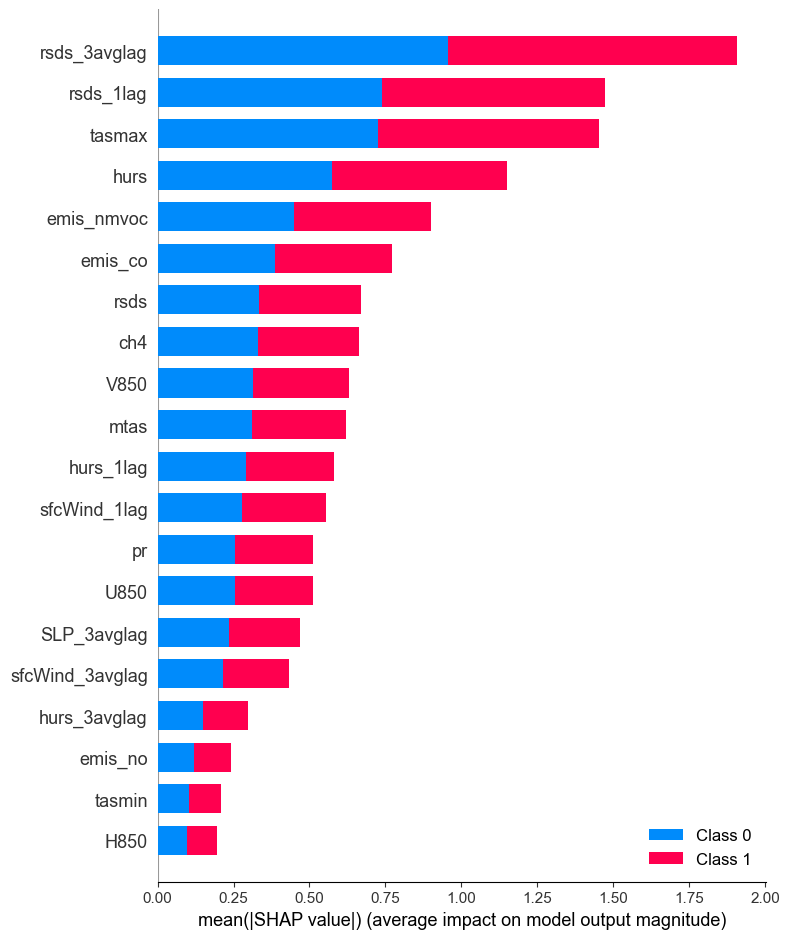

In [ ]:
shap.summary_plot(shap_values, X)
